<a href="https://colab.research.google.com/github/rajuzumaki2207/Time_series_Sequence/blob/main/TurboFan_Engine_RUL_WO_History.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## About data set
https://www.kaggle.com/datasets/behrad3d/nasa-cmaps


Prognostics and health management is an important topic in industry for predicting state of assets to avoid downtime and failures. This data set is the Kaggle version of the very well known public data set for asset degradation modeling from NASA. It includes Run-to-Failure simulated data from turbo fan jet engines.

Engine degradation simulation was carried out using C-MAPSS. Four different were sets simulated under different combinations of operational conditions and fault modes. Records several sensor channels to characterize fault evolution. The data set was provided by the Prognostics CoE at NASA Ames.

### Prediction Goal
In this dataset the goal is to predict the remaining useful life (RUL) of each engine in the test dataset. RUL is equivalent of number of flights remained for the engine after the last datapoint in the test dataset

### Data set features
Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sb
import xgboost as xgb
import lightgbm as lightgbm


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,GradientBoostingRegressor,GradientBoostingClassifier
# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, roc_auc_score, precision_score, recall_score, f1_score


## Model Selection
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

import os



In [3]:
## Read Data (By senson data from Dataset desc)

col = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]

In [4]:
## Train data
train = pd.read_csv("/content/drive/MyDrive/ML/Projects/RUL_TurboFan/train_FD001.txt", sep = " ", names=col)

In [5]:
train.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [6]:
## Test data
test = pd.read_csv("/content/drive/MyDrive/ML/Projects/RUL_TurboFan/test_FD001.txt", sep = " ", names =col)

In [7]:
test.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        20631 non-null  int64  
 1   cycle     20631 non-null  int64  
 2   op1       20631 non-null  float64
 3   op2       20631 non-null  float64
 4   op3       20631 non-null  float64
 5   sensor1   20631 non-null  float64
 6   sensor2   20631 non-null  float64
 7   sensor3   20631 non-null  float64
 8   sensor4   20631 non-null  float64
 9   sensor5   20631 non-null  float64
 10  sensor6   20631 non-null  float64
 11  sensor7   20631 non-null  float64
 12  sensor8   20631 non-null  float64
 13  sensor9   20631 non-null  float64
 14  sensor10  20631 non-null  float64
 15  sensor11  20631 non-null  float64
 16  sensor12  20631 non-null  float64
 17  sensor13  20631 non-null  float64
 18  sensor14  20631 non-null  float64
 19  sensor15  20631 non-null  float64
 20  sensor16  20631 non-null  fl

<font color="red">**Looks like sensors 22 and 23 are faulty**

In [9]:
## Check the same  for test set

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        13096 non-null  int64  
 1   cycle     13096 non-null  int64  
 2   op1       13096 non-null  float64
 3   op2       13096 non-null  float64
 4   op3       13096 non-null  float64
 5   sensor1   13096 non-null  float64
 6   sensor2   13096 non-null  float64
 7   sensor3   13096 non-null  float64
 8   sensor4   13096 non-null  float64
 9   sensor5   13096 non-null  float64
 10  sensor6   13096 non-null  float64
 11  sensor7   13096 non-null  float64
 12  sensor8   13096 non-null  float64
 13  sensor9   13096 non-null  float64
 14  sensor10  13096 non-null  float64
 15  sensor11  13096 non-null  float64
 16  sensor12  13096 non-null  float64
 17  sensor13  13096 non-null  float64
 18  sensor14  13096 non-null  float64
 19  sensor15  13096 non-null  float64
 20  sensor16  13096 non-null  fl

In [10]:
print ("Total Nulls in sensor 22 is" ,test.sensor22.isnull().sum())
print ("Total Nulls in sensor 23 is" ,test.sensor23.isnull().sum())

Total Nulls in sensor 22 is 13096
Total Nulls in sensor 23 is 13096


In [11]:
## Beautify plots

plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (20,10)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

In [12]:
## id are engine/fleet identification and cycles are flight cycles before failure
train.groupby('id')['cycle'].max()

id
1      192
2      287
3      179
4      189
5      269
      ... 
96     336
97     202
98     156
99     185
100    200
Name: cycle, Length: 100, dtype: int64

In [43]:
import plotly.express as px

fig =px.bar(train, x=train.id.unique(), y =train.groupby('id')['cycle'].count(), title="Engine ID v Cycle Time",labels={
                     "x": "Engine ID",
                     "y" : "Cycle"} , template="plotly_dark")
fig.show()

In [50]:
test_results=pd.read_csv("/content/drive/MyDrive/ML/Projects/RUL_TurboFan/RUL_FD001.txt",sep=" ",header=None)

In [52]:
test_results.drop(1, axis =1, inplace=True)

In [54]:
test_results.columns = ['RUL']

In [61]:
test_results['id'] =  test_results.index.values +1 

In [62]:
test_results

,RUL,id
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5
...,...,...
95,137,96
96,82,97
97,59,98
98,117,99


In [ ]:
test_results['rul_failed']

In [65]:
rul = test.groupby('id')['cycle'].count().reset_index()

In [71]:
rul.columns = ['id', 'max']


In [78]:
test_results['rul_failed']= test_results['RUL'].values + rul['max'].values


In [80]:
test_results.drop('RUL', axis =1, inplace=True)

In [83]:
test = test.merge(test_results, on = ['id'], how='left')

In [85]:
test['remaining_cycle'] = test["rul_failed"].values -test["cycle"].values

In [107]:
train['remaining_cycle'] = train.groupby('id')["cycle"].transform(max) -train["cycle"].values

In [87]:
test.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,rul_failed,remaining_cycle
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN,143,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN,143,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN,143,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN,143,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN,143,138


In [88]:
train.drop(["sensor22", "sensor23"], axis=1, inplace=True)  ## Sensor 22 and 23 are droped as NAN are the only value

In [89]:
test.drop(["sensor22", "sensor23"], axis=1, inplace=True)  ## Sensor 22 and 23 are droped as NAN are the only value

In [108]:
cycles = 30
train['label'] = train['remaining_cycle'].apply(lambda x: 1 if x <= cycles else 0)
test['label'] = test['remaining_cycle'].apply(lambda x: 1 if x <= cycles else 0)

In [109]:
op_set = ["op" + str(i) for i in range(1,4)]
sensor = ["sensor" + str(i) for i in range(1,22)]

In [138]:
test.columns

Index(['id', 'cycle', 'op1', 'op2', 'op3', 'sensor1', 'sensor2', 'sensor3',
       'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8', 'sensor9',
       'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
       'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21',
       'rul_failed', 'remaining_cycle', 'label'],
      dtype='object')

In [137]:
for i in range(1,21,3):

  fig = px.scatter_matrix(test, dimensions = ['cycle' , 'sensor' + str(i), 'sensor' + str(i+1), 'sensor' + str(i+2), 'sensor' + str(i+3)
  ], template ="plotly_dark")
  fig.show()

ValueError: ignored

In [139]:
test.drop(["id","cycle","op3","sensor1","sensor5","sensor6","sensor10","sensor16","sensor18","sensor19"],axis=1,inplace=True)

In [140]:
X= train.drop(["id","cycle","op3","sensor1","sensor5","sensor6","sensor10","sensor16","sensor18","sensor19","remaining_cycle","label"],axis=1)

In [141]:
y=train.label

## Train test Split

In [146]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=3)

In [147]:
import lightgbm as lgb

clf =  lgb.LGBMClassifier(
    learning_rate = 0.01,
    n_estimators=5000,
    num_leaves=100,
   objective='binary', 
   metrics='auc',
   random_state=50,
   n_jobs=-1)



In [148]:
clf.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.01, metrics='auc', n_estimators=5000,
               num_leaves=100, objective='binary', random_state=50)

In [149]:
clf.score(X_test, y_test)

0.9607463048219045

In [152]:
y_pred =clf.predict(X_test)
print('Acc Score: ',accuracy_score(y_test, y_pred))
print('Roc Auc Score: ',roc_auc_score(y_test,y_pred))
print('Precision Score: ',precision_score(y_test, y_pred))
print('Recall Score: ',recall_score(y_test, y_pred))
print('f1 score: ',f1_score(y_test, y_pred))

Acc Score:  0.9607463048219045
Roc Auc Score:  0.9117584198662763
Precision Score:  0.8883161512027491
Recall Score:  0.8420195439739414
f1 score:  0.8645484949832776


In [154]:
 fi = pd.Series(clf.feature_importances_)

In [157]:
Feature = X_train.columns.tolist()

In [158]:
df_FI = pd.DataFrame({"FI": fi, "Feature": Feature })

In [159]:
df_FI

,FI,Feature
0,27395,op1
1,16162,op2
2,27521,sensor2
3,28195,sensor3
4,27472,sensor4
5,27815,sensor7
6,17132,sensor8
7,27251,sensor9
8,22643,sensor11
9,26347,sensor12


In [164]:
df_FI.sort_values(by=["FI"], ascending=False)

,FI,Feature
12,30075,sensor15
3,28195,sensor3
11,28136,sensor14
15,28090,sensor21
5,27815,sensor7
2,27521,sensor2
4,27472,sensor4
0,27395,op1
7,27251,sensor9
9,26347,sensor12


In [166]:
df_FI = df_FI.sort_values(by=["FI"], ascending=False)
fig = px.bar(df_FI, x="Feature", y = "FI", template = "plotly_dark")
fig.show()

## XGboost and RandomSearch

In [167]:
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
stf_kf=StratifiedKFold(n_splits=5)
import xgboost as xgb
xgb_classifier=xgb.XGBClassifier(n_estimators=725,n_jobs=-1)
params={
         'learning_rate': np.arange(0.01, 0.11, 0.025),
         'max_depth': np.arange(1, 10, 1),
         'min_child_weight': np.arange(1, 10, 1), 
         'subsample': np.arange( 0.7, 1, 0.05), 
         'gamma': np.arange(0.5, 1, 0.1), 
         'colsample_bytree': np.arange( 0.1, 1, 0.05), 
         'scale_pos_weight': np.arange( 20, 200, 10)}
rs_cv_classifier=RandomizedSearchCV(xgb_classifier,param_distributions=params,cv=stf_kf,n_jobs=-1)
rs_cv_classifier.fit(X_train,y_train)
y_pred=rs_cv_classifier.predict(X_test)
print("Best Parameter: \n",rs_cv_classifier.best_params_)
print("XGBClassifier Acc Score: ",accuracy_score(y_pred,y_test))

Best Parameter: 
 {'subsample': 0.75, 'scale_pos_weight': 60, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.060000000000000005, 'gamma': 0.7999999999999999, 'colsample_bytree': 0.5500000000000002}
XGBClassifier Acc Score:  0.9556578628543736


In [169]:
y_pred = rs_cv_classifier.predict(X_test)

In [170]:
cm=confusion_matrix(y_test, y_pred)

In [171]:
print (cm)

[[3392  121]
 [  62  552]]


In [173]:
print("Test Accuracy Score: ", accuracy_score(y_test, y_pred))

Test Accuracy Score:  0.9556578628543736


In [174]:
print('Acc Score: ',accuracy_score(y_test, y_pred))
print('Roc Auc Score: ',roc_auc_score(y_test,y_pred))
print('Precision Score: ',precision_score(y_test, y_pred))
print('Recall Score: ',recall_score(y_test, y_pred))
print('f1 score: ',f1_score(y_test, y_pred))

Acc Score:  0.9556578628543736
Roc Auc Score:  0.9322896528575574
Precision Score:  0.8202080237741456
Recall Score:  0.8990228013029316
f1 score:  0.8578088578088577


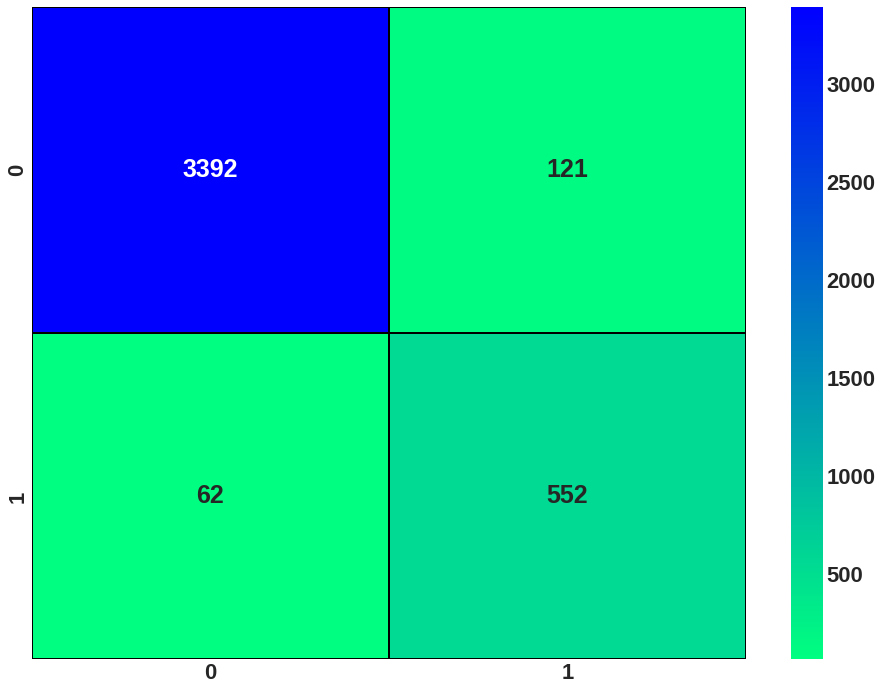

In [175]:
plt.figure(figsize=(16,12))
sb.heatmap(cm,annot=True,annot_kws={"size": 25},linewidths=0.7,linecolor="black",cmap="winter_r",fmt="d")